# Simple PPO Agent (CityLearn)
Minimal end-to-end example: load schema, keep only electrical storage, wrap env for single-building central agent, train PPO briefly, evaluate, and plot rewards.

In [1]:
# Basic imports & versions
import sys, os, json, time, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch as th
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-08-25 15:33:40.659990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 15:33:40.673223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756128820.687794 3562053 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756128820.692052 3562053 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756128820.703520 3562053 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


In [2]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv' 
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10

In [3]:
def keep_only_electrical_storage(schema: dict) -> dict:
    if 'actions' in schema:
        for a in list(schema['actions'].keys()):
            schema['actions'][a]['active'] = (a == 'electrical_storage')
    if 'buildings' in schema:
        for b in schema['buildings']:
            if 'actions' in b:
                for a in list(b['actions'].keys()):
                    b['actions'][a]['active'] = (a == 'electrical_storage')
    return schema

# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR

# Deactivate all actions except electrical storage if flag is set
if ONLY_ELECTRICAL_STORAGE:
    schema = keep_only_electrical_storage(schema)

schema['reward_function'] = REWARD_FN

# Set pricing file
price_file = PRICING_FILE
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

# Create underlying CityLearn environment (central agent)
env = CityLearnEnv(schema, central_agent=True)
print('Action_space building0:', env.action_space[0])
print('Observation length (building0):', len(env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-25_15-33-44'
Action_space building0: Box(-1.0, 1.0, (6,), float32)
Observation length (building0): 85


### Wrapper Environment (Continuous [-1,1] Storage Control)

In [4]:
class CityLearnPPOWrapper(gym.Env): # CityLearnEnv -> gym.Env (SB3)
    metadata = {'render_modes': []}
    def __init__(self, env: CityLearnEnv):
        super().__init__()
        self.env = env
        self.env.reset()
        obs0 = np.array(self.env.observations[0], dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=obs0.shape, dtype=np.float32)
        # Determine original action dimension
        orig_dim = self.env.action_space[0].shape[0]
        # If only electrical storage remains, orig_dim should be 1.
        # We still define a 1D agent action space; we'll expand to full if needed.
        self.agent_action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.action_space = self.agent_action_space
        # Try to find index of electrical storage if multiple dims survived (fallback 0)
        try:
            b0 = self.env.buildings[0]
            # Attempt to parse device ordering from building actions structure
            # If not available, default to index 0
            self.storage_index = 0
        except Exception:
            self.storage_index = 0
        self.orig_dim = orig_dim

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.env.reset(seed=seed)
        obs = np.array(self.env.observations[0], dtype=np.float32)
        return obs, {}

    def step(self, action):
        # Expect a single scalar in [-1,1]
        a = np.clip(np.array(action, dtype=np.float32).reshape(-1), -1.0, 1.0)
        if a.size != 1:
            raise ValueError(f"Expected single action value, got shape {a.shape}")
        frac = float(a[0])
        if self.orig_dim == 1:
            actions = [[frac]]
        else:
            # Build full vector of zeros, insert frac at storage index; others neutral (0)
            full = np.zeros(self.orig_dim, dtype=np.float32)
            full[self.storage_index] = frac
            actions = [full.tolist()]
        obs_all, rewards, terminated, truncated, info = self.env.step(actions)
        obs = np.array(obs_all[0], dtype=np.float32)
        reward = float(rewards[0])
        return obs, reward, bool(terminated), bool(truncated), info

    def render(self):
        pass

In [5]:
class StorageActionWrapper(gym.Env):
    def __init__(self, env: CityLearnEnv, storage_indices=None, scale='01'):
        super().__init__()
        self.env = env
        self.env.reset()
        # Original continuous action dimension (central agent)
        self.orig_dim = env.action_space[0].shape[0]
        # Identify storage action indices (if not supplied, assume all)
        self.storage_indices = storage_indices or list(range(self.orig_dim))
        # Single agent action per storage index (can generalize >1)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0,
                                           shape=(len(self.storage_indices),),
                                           dtype=np.float32)
        obs0 = np.array(env.observations[0], dtype=np.float32)
        obs_low = np.full_like(obs0, -5.0)
        obs_high = np.full_like(obs0, 5.0)
        self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)
        self.scale = scale  # '01' or 'sym'

    def reset(self, *, seed=None, options=None):
        self.env.reset(seed=seed)
        return np.array(self.env.observations[0], dtype=np.float32), {}

    def _map_actions(self, a_vec):
        # Start neutral
        full = np.zeros(self.orig_dim, dtype=np.float32)
        # Map each component
        for src_i, tgt_i in enumerate(self.storage_indices):
            raw = float(a_vec[src_i])
            if self.scale == '01':
                # [-1,1] -> [0,1]
                full[tgt_i] = 0.5 * (raw + 1.0)
            else:
                # assume underlying already expects [-1,1]
                full[tgt_i] = raw
        return [full.tolist()]

    def step(self, action):
        a = np.array(action, dtype=np.float32).reshape(-1)
        acts = self._map_actions(a)
        obs_all, rewards, term, trunc, info = self.env.step(acts)
        obs = np.array(obs_all[0], dtype=np.float32)
        # (Optional) clip obs for stability
        obs = np.clip(obs, -5.0, 5.0)
        return obs, float(rewards[0]), bool(term), bool(trunc), info

### PPO Callback for Logging

In [6]:
class PPOTrainLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rows = []  # per step
        self.ep_returns = []
        self._ep_ret = 0.0
    def _on_step(self):
        # Access locals: 'rewards', 'dones' if vectorized wrapper is used
        r = float(self.locals.get('rewards', [0])[0]) if isinstance(self.locals.get('rewards'), (list, tuple, np.ndarray)) else float(self.locals.get('rewards', 0))
        d = bool(self.locals.get('dones', [False])[0]) if isinstance(self.locals.get('dones'), (list, tuple, np.ndarray)) else bool(self.locals.get('dones', False))
        self._ep_ret += r
        self.rows.append({'timestep': int(self.num_timesteps), 'reward': r})
        if d:
            self.ep_returns.append(self._ep_ret)
            self._ep_ret = 0.0
            return True
    def _on_training_end(self):
        import pandas as pd
        self.step_df = pd.DataFrame(self.rows)
        self.ep_df = pd.DataFrame({'episode': range(1, len(self.ep_returns)+1), 'return': self.ep_returns})

### Build & Train PPO

In [7]:
def make_env():
    base = CityLearnEnv(schema, central_agent=True)
    return Monitor(StorageActionWrapper(base, scale='01'))

vec_env = DummyVecEnv([make_env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=5.0)

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-25_15-33-46'


In [ ]:
# old:
# env = Monitor(CityLearnPPOWrapper(env))

log_dir = r'/hkfs/home/haicore/iai/cj9272/logs/ppo'

wrapped_env = StorageActionWrapper(env)
env = Monitor(wrapped_env, filename=os.path.join(log_dir, "monitor.csv"))
logger = PPOTrainLogger()
TOTAL_TIMESTEPS = 2208 * 40

model = PPO(
    policy='MlpPolicy',
    env=vec_env,
    seed=0,
    device='cpu',
    learning_rate=3e-4,
    n_steps=512,
    batch_size=256, # number of experiences used for one iteration of a gradient descent update. This should always be a fraction of the buffer_size
    gamma=0.99, # discount factor future rewards
    gae_lambda=0.95, 
    clip_range=0.2,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU)
)
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=logger)
print(f"Total elapsed for training {TOTAL_TIMESTEPS} steps: {(time.time()-start_time) / 60:.2f} minutes")

model.save("ppo_01")  # saving the model to ppo_01.zip 
vec_env.save("venv_stats.pkl")

Using cuda device


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Total elapsed for training 88320 steps: 0.00 minutes


### Quick Evaluation

In [9]:
def evaluate(model, env, episodes=1):
    returns = []
    for i in range(episodes):
        obs, _ = env.reset()
        done = False
        ret = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            # action expected shape (1,) from wrapper
            prev_soc = env.env.env.buildings[0].electrical_storage.soc.copy() #new
            obs, r, term, trunc, _ = env.step(action) 
            new_soc = env.env.env.buildings[0].electrical_storage.soc.copy() #new
            print("ΔSOC", (new_soc - prev_soc).mean(), "action", action) #new
            ret += r
            done = term or trunc
        returns.append(ret)
        print(f"Return of episode {i + 1}: {ret}")
    return np.array(returns)


# Build eval env and copy normalization stats from training vec_env (already in memory)
eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize.load("venv_stats.pkl", eval_env)
eval_env.training = False
eval_env.norm_reward = False  # report true reward

model = PPO.load("ppo_01")  # loading the model from ppo_01.zip             

"""
eval_returns = evaluate(model, eval_env, episodes=EVAL_EPISODES)
print(f'Eval mean return over {EVAL_EPISODES} ep(s):', eval_returns.mean())

if hasattr(logger, 'step_df'): logger.step_df.to_csv('train_steps.csv', index=False)
if hasattr(logger, 'ep_df'): logger.ep_df.to_csv('episode_returns.csv', index=False) 
"""                    

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-25_15-33-49'


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


"\neval_returns = evaluate(model, eval_env, episodes=EVAL_EPISODES)\nprint(f'Eval mean return over {EVAL_EPISODES} ep(s):', eval_returns.mean())\n\nif hasattr(logger, 'step_df'): logger.step_df.to_csv('train_steps.csv', index=False)\nif hasattr(logger, 'ep_df'): logger.ep_df.to_csv('episode_returns.csv', index=False) \n"

In [ ]:
# Enhanced evaluation: timings, episode length, per-step stats, deterministic toggle.
import time, numpy as np, pandas as pd

def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False):
    """
    Returns (metrics_df, all_step_rewards_array)
    metrics_df columns: episode, return, length, mean_reward, min_step_reward,
                        max_step_reward, std_step_reward, steps_per_sec, wall_time_s
    """
    ep_metrics = []
    all_step_rewards = []
    t_global_start = time.time()

    for ep in range(1, episodes+1):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        ep_len = 0
        step_rewards = []
        t_ep_start = time.time()

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            print(f"Action taken: {action}")
            obs, r, term, trunc, _ = env.step(action)
            ep_ret += r
            step_rewards.append(r)
            ep_len += 1
            done = term or trunc
            if render:
                env.render()

        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep,
            'return': ep_ret,
            'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec,
            'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)
        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")

    total_time = time.time() - t_global_start
    print(f"Total eval time: {total_time:.2f}s  | Avg/ep: {total_time/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)
    return metrics_df, np.array(all_step_rewards)

# Example usage (choose one):
metrics_det, step_rewards_det = evaluate_with_metrics(model, env, episodes=EVAL_EPISODES, deterministic=True)
# metrics_stoch, step_rewards_stoch = evaluate_with_metrics(model, env, episodes=EVAL_EPISODES, deterministic=False)

Action taken: [-0.6646707   0.25067052 -0.25134    -0.50320613  0.07612136  0.3649389 ]
Action taken: [-0.01006215  0.02062355 -0.01488192  0.00895393  0.00594908  0.01466843]
Action taken: [-0.01798533  0.02242135 -0.01645623  0.00510908  0.00470983  0.01481127]
Action taken: [-0.01706035  0.02190079 -0.01683681  0.00686959  0.00604406  0.01452397]
Action taken: [-0.01464737  0.02112863 -0.01584485  0.00531324  0.00588565  0.01418254]
Action taken: [-0.01776385  0.02346027 -0.01830082  0.00445744  0.00438887  0.0129333 ]
Action taken: [-0.0042572   0.0113903  -0.01864411 -0.00012461  0.01520145  0.01649344]
Action taken: [-0.00387716  0.0094665  -0.02075563  0.00366016  0.01355148  0.01210865]
Action taken: [-0.0045844   0.00945151 -0.02211355  0.00666157  0.01928523  0.01239583]
Action taken: [-0.00456474  0.00873765 -0.01911226  0.00200677  0.01970066  0.01415914]
Action taken: [-0.00837436  0.00965885 -0.02305639 -0.00042085  0.01911929  0.01426488]
Action taken: [-0.00158142  0.01

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x14c461985f50>>
Traceback (most recent call last):
  File "/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Action taken: [-0.01773387  0.02211663 -0.01901677  0.00604685  0.00334649  0.01187268]
Action taken: [-0.01533596  0.02328257 -0.01829623  0.00756972  0.00627555  0.01466166]
Action taken: [-0.00443727  0.01588344 -0.02019841 -0.00060573  0.01083136  0.01467746]
Action taken: [-0.00074538  0.00968892 -0.02407244  0.00613575  0.00405927  0.00920145]
Action taken: [-0.00584273  0.01253029 -0.02026781  0.00911126  0.01235308  0.01278897]
Action taken: [-0.00221877  0.01099842 -0.02127183  0.00883889  0.01414126  0.013174  ]
Action taken: [ 0.00384388  0.00782416 -0.02047775  0.00738403  0.01616304  0.01242862]
Action taken: [ 0.00320322  0.00833135 -0.02010889  0.00649018  0.01471531  0.01276127]
Action taken: [ 0.00383668  0.00867725 -0.01868702  0.00685189  0.01505069  0.01305916]
Action taken: [-0.00110315  0.01321135 -0.02344448  0.00647163  0.01437736  0.00947725]
Action taken: [-0.00321203  0.0132107  -0.02605684  0.00739712  0.01112915  0.00756344]
Action taken: [-0.00195626  0.01

### Plots

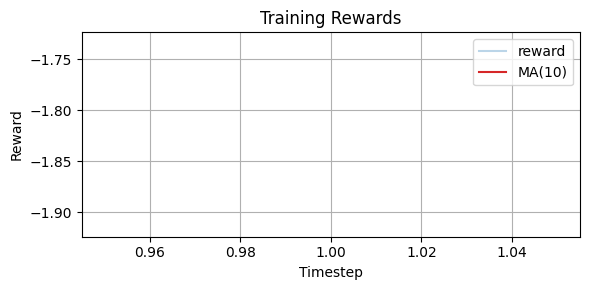

In [ ]:
import pandas as pd
if hasattr(logger, 'step_df'):
    step_df = logger.step_df.copy()
    if not step_df.empty:
        # Reward moving average
        window = min(1000, max(10, len(step_df)//20))
        step_df['reward_ma'] = step_df['reward'].rolling(window, min_periods=1).mean()
        plt.figure(figsize=(6,3))
        plt.plot(step_df['timestep'], step_df['reward'], alpha=0.3, label='reward')
        plt.plot(step_df['timestep'], step_df['reward_ma'], color='C3', label=f'MA({window})')
        plt.xlabel('Timestep'); plt.ylabel('Reward'); plt.title('Training Rewards'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
if hasattr(logger, 'ep_df') and len(logger.ep_df):
    ep_df = logger.ep_df
    plt.figure(figsize=(5,3))
    plt.plot(ep_df['episode'], ep_df['return'], marker='o')
    plt.xlabel('Episode'); plt.ylabel('Return'); plt.title('Episode Returns'); plt.grid(True); plt.tight_layout(); plt.show()

### Next Ideas
- Add VecNormalize for observation/reward normalization.
- Add EvalCallback for periodic evaluation.
- Tune hyperparameters (n_steps, batch_size, gamma).
- Switch reward function (ComfortReward etc.).
- Multi-building or multi-agent variants.